This code requires a decent GPU to work in a reasonable length of time. Install the appropriate JAX version to support CUDA etc.

In [1]:
import jax
print(jax.devices())

[CpuDevice(id=0)]


In [1]:
import numpy as np

from jax import jit
from jaxdf import FourierSeries
import jax.numpy as jnp

from jwave.acoustics import simulate_wave_propagation
from jwave.geometry import Domain, TimeAxis, BLISensors, Medium
from jwave.acoustics.time_varying import TimeWavePropagationSettings
from jwave.signal_processing import smooth as smooth_jwave

from patato.recon.fourier_transform_rec import FFTReconstruction
from skimage import filters

from tqdm import tqdm


def smooth(image):
    # return filters.gaussian(image, sigma=1)
    # return image
    return smooth_jwave(image)


import matplotlib.pyplot as plt

from scipy.signal import butter, filtfilt, hilbert
from scipy.interpolate import RegularGridInterpolator

from paiskintonetools import setup_matplotlib

setup_matplotlib(dpi=100)

from pa_to_us import reconstruct_plane_wave_us, ft_to_image

First, let's define the simulation parameters. 

In [2]:
## Define the simulation grid
Nx = 512  # width and height of the grid
dx = 0.2e-3  # m
domain = Domain((Nx, Nx), (dx, dx))

## Define the background speed of sound and density
c0 = 1540  # m/s
rho0 = 1000  # kg/m3

## Define the simulation time samples
dt = 1 / 4e7
t_end = 1e-4
time_axis = TimeAxis(dt=dt, t_end=t_end)

# This is the relative intensity of the blood vessel. 
# To reproduce the results in the paper, vary this from 0.0001 to 10.
# It will save the corresponding results in intermediate_results. These
# results are then called in figure-making scripts.
blood_vessel = 0.001

In [3]:
def pixels_to_positions(x=None, y=None):
    if x is None and y is None:
        raise ValueError("Either x or y must be defined.")
    elif x is None:
        return (y - Nx / 2) * dx
    elif y is None:
        return (x - Nx / 2) * dx
    else:
        return ((x - Nx / 2) * dx, (y - Nx / 2) * dx)


def positions_to_pixels(x=None, y=None):
    if x is None and y is None:
        raise ValueError("Either x or y must be defined.")
    elif x is None:
        return y / dx + Nx / 2
    elif y is None:
        return x / dx + Nx / 2
    else:
        return (x / dx + Nx / 2, y / dx + Nx / 2)


def get_scatterers(n=3, radius=0.0015, y0=0):
    grid = np.zeros(domain.N, dtype=bool)
    xs = pixels_to_positions(np.arange(domain.N[0]))[None, :]
    ys = pixels_to_positions(np.arange(domain.N[0]))[:, None]
    for i in range(n):
        for j in range(n):
            mask = (xs - radius * 5 * (i - n // 2)) ** 2 + (
                ys + radius + radius * 5 * j
            ) ** 2 < radius**2
            grid[mask] = True
    # mask = ((ys > -0.01) & (ys<0))[:, 0]
    # grid[mask, :] = True
    return grid


def get_p0(delta_y, y0=0, width=0.05):
    grid = np.zeros(domain.N)
    Ny = int(positions_to_pixels(y=y0 + delta_y))
    Nx = positions_to_pixels(x=np.array([-width / 2, width / 2])).astype(int)
    grid[Ny, Nx[0] : Nx[1]] = 1
    # Vessels:
    if blood_vessel is not None:
        xs = pixels_to_positions(np.arange(domain.N[0]))
        grid[
            xs[:, None] ** 2 + (xs[None, :] - 0.0025) ** 2 < 0.0025**2
        ] = blood_vessel
    return grid


def get_linear_sensors(y0=0, width=0.04, Ndet=256):
    x = np.linspace(-width / 2, width / 2, Ndet)
    y = np.zeros_like(x) + y0
    return x, y, "LINEAR"


def get_arc_shaped_sensors(y0=0, radius=0.04, Ndet=256, angle=120):
    theta = np.linspace(np.deg2rad(-angle / 2), np.deg2rad(angle / 2), Ndet)
    x = radius * np.sin(theta)
    y = radius * np.cos(theta)
    return x, y, "ARC"


def run_simulations(p0, detectors: list[np.ndarray], density=rho0, sound_speed=c0):
    """
    Note: sensors is a list of np.ndarray
    """
    if np.isscalar(density):
        density = np.ones(domain.N) * density
    density = FourierSeries(jnp.expand_dims(density, -1), domain)
    if np.isscalar(sound_speed):
        sound_speed = np.ones(domain.N) * sound_speed
    sound_speed = FourierSeries(jnp.expand_dims(sound_speed, -1), domain)

    p0 = FourierSeries(jnp.expand_dims(p0, -1), domain)

    medium = Medium(
        domain=domain, sound_speed=sound_speed, density=density, pml_size=20
    )

    bli_sensors = [
        BLISensors(positions=positions_to_pixels(y, x), n=domain.N)
        for x, y in detectors
    ]
    sensors = lambda *args: [bli(*args) for bli in bli_sensors]

    @jit
    def compiled_simulator():
        return simulate_wave_propagation(
            medium,
            time_axis,
            p0=p0,
            sensors=sensors,
            settings=TimeWavePropagationSettings(smooth_initial=True),
        )

    pressure = compiled_simulator()
    return [np.asarray(p)[:, :, 0] for p in pressure]

Define the sensors, inhomogeneity parameters, and initial pressure.

In [4]:
extent = pixels_to_positions(np.array([-0.5, Nx - 0.5] * 2))

y_skin = 0.005
y_lineararray = 0.02
width_skin = 0.05
width_detectors = 0.04 * np.sqrt(3)  # 4
radius_detectors = 0.04

p0_grid = get_p0(y_skin, width=width_skin)
xs = pixels_to_positions(np.arange(Nx))

xsens_arc, ysens_arc, sensor_type_arc = get_arc_shaped_sensors(radius=radius_detectors)
xsens, ysens, sensor_type = get_linear_sensors(y_lineararray, width=width_detectors)

# Define the inhomogeneous simulation.
density = np.ones_like(p0_grid) * rho0
sound_speed = np.ones_like(p0_grid) * c0
noise = np.random.normal(size=domain.N, loc=1, scale=0.008)
density *= noise
sound_speed *= noise

mask = get_scatterers()
n_pixels = np.sum(mask)
random_weighting = np.random.normal(
    size=domain.N, loc=25 + c0, scale=75
)  # to mimic scattering.
density[mask] = random_weighting[mask] / 1.5
sound_speed[mask] = random_weighting[mask]

In [5]:
c = p0_grid.shape[0] // 2
p0_save = smooth_jwave(p0_grid[c - 100 : c + 100, c - 100 : c + 100])
density_save = smooth_jwave(density[c - 100 : c + 100, c - 100 : c + 100])
if blood_vessel is None:
    np.save("intermediate_results/p0.npy", p0_save)
    np.save("intermediate_results/density.npy", density_save)
else:
    bv_amount = np.log10(blood_vessel)
    np.save(f"intermediate_results/p0_bv1E{bv_amount:.0f}.npy", p0_save)

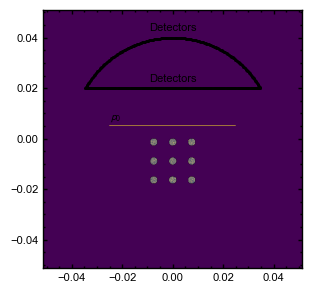

In [6]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(p0_grid, origin="lower", extent=extent, cmap="viridis")

sound_speed_vis = sound_speed.copy()
sound_speed_vis[~mask] = np.nan
ax.imshow(sound_speed_vis, origin="lower", extent=extent, cmap="cividis")
ax.annotate(
    "$p_0$",
    (-width_skin / 2, y_skin),
    (0, 5),
    xycoords="data",
    textcoords="offset points",
)

ax.scatter(xsens, ysens, marker="o", c="k", s=1)
text_i = ysens.shape[0] // 2
ax.annotate(
    "Detectors",
    (xsens[text_i], ysens[text_i]),
    (0, 5),
    xycoords="data",
    textcoords="offset points",
    ha="center",
)  # if text_i != 0 else "left")

ax.scatter(xsens_arc, ysens_arc, marker="o", c="k", s=1)
text_i = ysens_arc.shape[0] // 2
ax.annotate(
    "Detectors",
    (xsens_arc[text_i], ysens_arc[text_i]),
    (0, 5),
    xycoords="data",
    textcoords="offset points",
    ha="center",
)  # if text_i != 0 else "left")

plt.show()

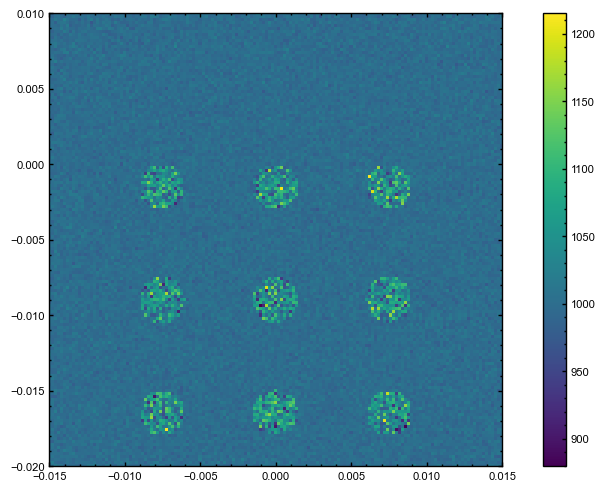

In [7]:
plt.imshow(density, origin="lower", extent=extent)
plt.ylim((-0.02, 0.01))
plt.xlim((-0.015, 0.015))
plt.colorbar()

Calculate the time series data.

In [ ]:
if blood_vessel is None:
    pressure_homog = run_simulations(p0_grid, [(xsens, ysens), (xsens_arc, ysens_arc)])
pressure_inhomog = run_simulations(
    p0_grid,
    [(xsens, ysens), (xsens_arc, ysens_arc)],
    density=density,
    sound_speed=sound_speed,
)

In [ ]:
if blood_vessel is None:
    np.save("intermediate_results/linear_homog.npy", pressure_homog[0])
    np.save("intermediate_results/arc_homog.npy", pressure_homog[1])
    np.save("intermediate_results/linear_inhomog.npy", pressure_inhomog[0])
    np.save("intermediate_results/arc_inhomog.npy", pressure_inhomog[1])
else:
    bv_amount = np.log10(blood_vessel)
    np.save(
        f"intermediate_results/linear_inhomog_bv1E{bv_amount:.0f}.npy",
        pressure_inhomog[0],
    )
    np.save(
        f"intermediate_results/arc_inhomog_bv1E{bv_amount:.0f}.npy", pressure_inhomog[1]
    )

In [ ]:
np.save("arc_detector.npy", np.stack([xsens_arc, ysens_arc, np.zeros_like(xsens_arc)]))

Now let's try a RUCT simulation? 

In [ ]:
## Define the simulation time samples
dt = 1 / 4e7
t_end = 2e-4
time_axis = TimeAxis(dt=dt, t_end=t_end)

In [ ]:
from jwave.signal_processing import gaussian_window

In [ ]:
t = np.arange(0, time_axis.t_end, time_axis.dt)
s = np.sin(2 * np.pi * 4e6 * t)
s1 = gaussian_window(s, t, 2e-6, 4e-7)
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(t, s1)
ax.axvline(2e-6, c="C1")
ax.set_xlim([0, 5e-6])
ax.set_xlabel("Time (s)")
ax.set_ylabel("Signal")
ax.set_title("Transmitted ultrasound pulse")
plt.show()

In [ ]:
ft_f = np.fft.fftshift(np.fft.fftfreq(s.shape[0], time_axis.dt))
ft_s = np.fft.fftshift(np.fft.fft(s))

plt.plot(ft_f, np.log(np.abs(ft_s)))
plt.axvline(4e6, c="C1")
plt.axvline(-4e6, c="C1")
plt.axvline(3e6, c="C1")
plt.axvline(5e6, c="C1")

In [ ]:
# Extend the BLISensors class to allow slicing and to be a source.
# b = BLISensors()


class BLISensorSource(BLISensors):
    def __init__(self, bx, by, bz, positions, n, signals):
        self.bx = bx
        self.by = by
        self.bz = bz
        self.n = n
        self.positions = positions
        self.signals = signals

    def tree_flatten(self):
        children = self.bx, self.by, self.bz, self.positions, self.signals
        aux = (self.n,)
        return children, aux

    @classmethod
    def tree_unflatten(cls, aux, children):
        return cls(*children[:-1], *aux, children[-1])

    @classmethod
    def from_positions_n(cls, positions, n, signals):
        blis = BLISensors(positions, n)
        return cls(blis.bx, blis.by, blis.bz, blis.positions, blis.n, signals)

    def on_grid(self, idx):
        # Time index idx - convert to integer.
        idx = idx.astype(jnp.int32)

        sig = self.signals[:, idx]
        if len(self.positions) == 1:
            return jnp.sum(sig[:, None, None] * self.bx, axis=0)
        elif len(self.positions) == 2:
            return jnp.sum(
                sig[:, None, None, None] * self.bx * self.by[:, None], axis=0
            )
        elif len(self.positions) == 3:
            return jnp.sum(
                sig[:, None, None, None] * self.bx * self.by[:, None], axis=0
            )
        else:
            raise ValueError("Sensor/source positions must be 1, 2, or 3 dimensional.")


source = np.zeros((256, int(time_axis.Nt)))
source[:, 0] = 1

In [ ]:
time_axis.Nt

In [ ]:
# b2 = BLISensors(d)

In [ ]:
def run_simulations_us(detectors, density=rho0, sound_speed=c0):
    """
    Note: sensors is an 2-tuple of 1-d numpy arrays (x detector positions, y detector positions).
    """
    if np.isscalar(density):
        density = np.ones(domain.N) * density
    density = FourierSeries(jnp.expand_dims(density, -1), domain)
    if np.isscalar(sound_speed):
        sound_speed = np.ones(domain.N) * sound_speed
    sound_speed = FourierSeries(jnp.expand_dims(sound_speed, -1), domain)

    medium = Medium(
        domain=domain, sound_speed=sound_speed, density=density, pml_size=20
    )

    bli_sensors = BLISensorSource.from_positions_n(
        positions=tuple(
            map(jnp.array, positions_to_pixels(detectors[1], detectors[0]))
        ),
        n=domain.N,
        signals=jnp.array(source),
    )

    @jit
    def compiled_simulator(i=0):
        signals = jnp.zeros_like(source)
        signals = signals.at[i].set(s1)
        bli_sensors.signals = signals
        return simulate_wave_propagation(
            medium,
            time_axis,
            sensors=bli_sensors,
            settings=TimeWavePropagationSettings(smooth_initial=True),
            sources=bli_sensors,
        )

    pressures = []
    for i in tqdm(range(detectors[0].shape[0])):
        pressure = compiled_simulator(i)
        pressures.append(pressure)
    return pressures

In [ ]:
pressures_linear = run_simulations_us((xsens, ysens), density, sound_speed)

In [ ]:
pl = np.stack(pressures_linear)

In [ ]:
np.save("intermediate_results/us_linear_inhomog.npy", pl)

In [ ]:
pressures_arc = run_simulations_us((xsens_arc, ysens_arc), density, sound_speed)

In [ ]:
pl = np.stack(pressures_arc)

In [ ]:
np.save("intermediate_results/us_arc_inhomog.npy", pl)

In [ ]:
pressures_linear = run_simulations_us((xsens, ysens), density, sound_speed)

In [ ]:
pl = np.stack(pressures_linear)

In [ ]:
np.save("intermediate_results/us_linear_inhomog.npy", pl)